# Exploring the Data Space of the Space Data Explorers

## In this notebook we will use the Twitter API to explore the conversation happening on Twitter related to NASA and Space Apps.

In [1]:
import pandas as pd
import scipy as sp
import random as rdm
import requests  # better than the urllib libraries
import simplejson
from requests_oauthlib import OAuth1
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

import re
from nltk.tokenize import word_tokenize
from string import punctuation 
from nltk.corpus import stopwords 
from textblob import TextBlob
import heapq
from collections import Counter
from wordcloud import WordCloud
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import DBSCAN
from itertools import islice, chain
from IPython.display import Image
from IPython import display
import matplotlib.pylab as plt
%matplotlib inline
import pysal as ps
from pysal.contrib.viz import mapping as maps
from pylab import *

from pylab import rcParams
rcParams['figure.figsize'] = 12, 7

import sys
from twython import Twython
import os
from datetime import datetime


import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

### We need twitter credentials in order to use the API. For more info on how to obtain them go to https://developer.twitter.com/en/docs

In [3]:

#twitter_secrets.json.nogit
secrets = {"api_key": CONSUMER_KEY,
           "api_secret": CONSUMER_SECRET,
           "access_token": ACCESS_KEY,
           "access_token_secret": ACCESS_SECRET}

auth = OAuth1(
    secrets["api_key"],
    secrets["api_secret"],
    secrets["access_token"],
    secrets["access_token_secret"]
)

# Let's create a function to request the posts we are interested in.

In [6]:
#L = []

def tweet_generator():
    """ Generator that live streams tweets (see 'yield' keyword)"""
    stream = requests.post('https://stream.twitter.com/1.1/statuses/filter.json',
                           auth=auth, 
                           stream=True,
                           data={"track":["nasa", 
                                          #"@nasa",
                                          #"#nasa",
                                          "spaceapps"#, 
                                          #"spaceappschallenge"
                                         ]#, 
                                 #"languages":"en"#
                                })
    
    for line in stream.iter_lines():
        if not line:  # filter out keep-alive new lines
            continue
        tweet = simplejson.loads(line)
        if ('text' in tweet): # and ((tweet['coordinates']) or (tweet['place'])):
            L.append(tweet)
            yield tweet['text']

### Let's use that function to get a 1000 tweets!

In [404]:
c = 0
for tweet in islice(tweet_generator(), 1000):
    c += 1
    if c % 100 == 0:
        print('\n')
        print(c)
        print('\n')
    print(tweet)

@NASA @Astro_Christina @Astro_Jessica @Space_Station My astronaut is so inspired. https://t.co/65Lh27vaWr
RT @maarcos_go: a nasa tem que estudar o @VintageCulture https://t.co/dzZXSLx0u6
RT @HillaryClinton: When I was a little girl, I wrote to NASA and told them I dreamed of being an astronaut. 

They wrote back and said the‚Ä¶
RT @CarpeDonktum: On the list of "things that never happened" this ranks right up there with you becoming President. https://t.co/o3W41WMIOM
Hahahahaha... deep  breath......hahahahaha!! 

Did you see the latest load of bull? üò≥

Killary said NASA wrote her‚Ä¶ https://t.co/ceqFbTs3Mr
RT @SirHublife: They should have launched this bitch into space when they had the chance.

Thanks a lot NASA. https://t.co/AXqMDdXCWb
RT @HillaryClinton: When I was a little girl, I wrote to NASA and told them I dreamed of being an astronaut. 

They wrote back and said the‚Ä¶
@TJWalters16 @TipaOdiosa @El_Papageno @RstrixxX @NASA @Astro_Christina @Astro_Jessica Civilized world is a 

RT @HillaryClinton: When I was a little girl, I wrote to NASA and told them I dreamed of being an astronaut. 

They wrote back and said the‚Ä¶
RT @AlterPinoyBott: #Kantot ako ni #Daddy habang nasa work pa si Mommy... Follow me for more HOT VIDEOS of my #Libog #Sex-perience.üî•üçÜüçë

#al‚Ä¶
Nasa Rome na akooo! 

Jk. Sa Goshen lang yan üòò

(c)@judslosito @ Goshen Resort and Hotel https://t.co/Q0Kv32iH5z
RT @HillaryClinton: When I was a little girl, I wrote to NASA and told them I dreamed of being an astronaut. 

They wrote back and said the‚Ä¶
RT @4AllSoulKind: BULLSHIT! 
Publish the letter. 
cc @POTUS #KAG https://t.co/RVq49TbOzo
RT @nytimes: 2 NASA astronauts, Christina Koch and Jessica Meir, completed the first all-female spacewalk on Friday. The walk lasted 7 hour‚Ä¶
RT @HillaryClinton: When I was a little girl, I wrote to NASA and told them I dreamed of being an astronaut. 

They wrote back and said the‚Ä¶
RT @nytimes: 2 NASA astronauts, Christina Koch and Jessica Meir, comple

RT @jondaly: Two women floating in space were forced to talk to a rapist. https://t.co/IAAXXUqpID
RT @menggalurks: Isa Pa With Feelings Review @Black_SheepPH 

#IsaPaFeelGoodWeekend
#MaineMendoza https://t.co/FqlFyKuBTx
RT @YahooNewsTopics: „ÄêÂè≤‰∏äÂàù Â•≥ÊÄß„Å†„Åë„ÅßÂÆáÂÆôÈÅäÊ≥≥„Äë
https://t.co/cCr7GlnJNp

ÂõΩÈöõÂÆáÂÆô„Çπ„ÉÜ„Éº„Ç∑„Éß„É≥„Åß18Êó•„ÄÅNASA„ÅÆÈ£õË°åÂ£´2‰∫∫„Åå„ÄÅÂè≤‰∏äÂàù„ÅÆÂ•≥ÊÄß„ÅÆ„Åø„Å´„Çà„ÇãÂÆáÂÆôÈÅäÊ≥≥„ÇíË°å„Å£„Åü„ÄÇ3Êúà„Å´„ÇÇ‰∫àÂÆö„Åï„Çå„Å¶„ÅÑ„Åü„Åå„ÄÅ„Çµ„Ç§„Ç∫„ÅÆÂêà„ÅÜÂÆáÂÆôÊúç„Åå„Åù„Çç„Çè„ÅöÂÆüÊñΩ„Åï‚Ä¶
laging ikaw nasa panaginip ko
RT @SirHublife: They should have launched this bitch into space when they had the chance.

Thanks a lot NASA. https://t.co/AXqMDdXCWb
RT @osodorna: iyak count ko sa isa pa with feelings: tatlo*

* isa nasa first 15 minutes ng palabas TAMA HO BA IYON pabiglang atake ahmpuht‚Ä¶
RT @Karnagemvp: JE CHIALE LES R√âPONSES üò≠üò≠üò≠üò≠üò≠ https://t.co/1VRgmU5lej
RT @GuyChicago5151: .@HillaryClinton Show US the letter, you know you didn‚Äôt 

NASA Is About to Conduct Its First All-Female Spacewalk https://t.co/wWZIOr80oO
@rokro111 @scottb_CITY @Freedom4thekids @FlatEarthExpert @_Gravity_Man @PaleAleWitch1 @Xaquery1 @dtjaayne @Mctoon27‚Ä¶ https://t.co/I2tZLB9s2S
RT @HillaryClinton: When I was a little girl, I wrote to NASA and told them I dreamed of being an astronaut. 

They wrote back and said the‚Ä¶
RT @catturd2: One time - at band camp! https://t.co/YZVvlBywgl
RT @HillaryClinton: When I was a little girl, I wrote to NASA and told them I dreamed of being an astronaut. 

They wrote back and said the‚Ä¶
RT @NASA: Today, history was made as @Astro_Jessica and @Astro_Christina successfully completed the first #AllWomanSpacewalk! For more than‚Ä¶
RT @HillaryClinton: When I was a little girl, I wrote to NASA and told them I dreamed of being an astronaut. 

They wrote back and said the‚Ä¶
RT @HillaryClinton: When I was a little girl, I wrote to NASA and told them I dreamed of being an astronaut. 

They wrote back and said the‚Ä¶

RT @YourMajo: Sana nasa tabi kita
RT @fabbrdn: Mdrrr y‚Äôa autant de poussi√®re que sa sur la Lune ? https://t.co/OwcLlnZOZF
RT @pialicerio: Ang galing lang kasi, napafeel niyo sa amin yung pakiramdam ng isang deaf, ang hirap kapag ikaw yung nasa sitwasyon ni gali‚Ä¶
RT @darna817: Pansin ko lang. Ano yung nasa likod Paps? Yung may pa ilaw. May naalala lang ako. ü§ü

BASTAHAPIKAHAPISYA

#ALDUBChangingLives‚Ä¶
RT @TaraForTrump: Hahahahaha... deep  breath......hahahahaha!! 

Did you see the latest load of bull? üò≥

Killary said NASA wrote her &amp; said‚Ä¶
RT @AlterPinoyBott: #Kantot ako ni #Daddy habang nasa work pa si Mommy... Follow me for more HOT VIDEOS of my #Libog #Sex-perience.üî•üçÜüçë

#al‚Ä¶
@HillaryClinton NASA didn‚Äôt take little girls, so Hillary showed them how.  Girls, boys, whatever Haiti had.  She t‚Ä¶ https://t.co/98l30AYl0j
RT @NASA: Today, history was made as @Astro_Jessica and @Astro_Christina successfully completed the first #AllWomanSpacewalk! For more than‚

RT @amyklobuchar: A great day in history. This is why I've always been a strong advocate for women in STEM, passing legislation that encour‚Ä¶
RT @StrongIam: Qing Inang commercial to! Hahaha

Basahin nyo yung nasa baba. https://t.co/uIS21dSnjl
@httpsxjane nasa bahay ako e
RT @p_k_rogers: @HeatherIsTaken Now NASA cheated her. LET IT REST @HillaryClinton , PLEASE,LET IT REST
RT @aspiringinvntor: üöÄTheüíÉ FIRST üíÉALL-FEMALE SPACEWALKüë©üèΩ is üëØüë©üèΩunderwayüë≠
what a week this has been for WOMEN! 

After that iconic photo of‚Ä¶
RT @Redtowel4: This right here is such a BS lie. https://t.co/DDGKy6wKDq
I call BULLSHIT üö© on this one. My mother also write a letter in '61 to NASA, but instead of being told "they don't‚Ä¶ https://t.co/7jfnkuxfEq
RT @NASA: Today, history was made as @Astro_Jessica and @Astro_Christina successfully completed the first #AllWomanSpacewalk! For more than‚Ä¶
RT @HillaryClinton: When I was a little girl, I wrote to NASA and told them I dreamed of being

Trump Speaks to NASA Astronauts During the First All-Women Spacewalk https://t.co/WQTSuWHzX2 via @epochtimes
RT @Tony__Heller: YouTube comment

"I‚Äôm literally petrified of climate change as I have anxiety disorder, it makes everything worse, I‚Äôve t‚Ä¶
Women can do anything üõ∞üåéüë©üèª‚ÄçüöÄ
RT @StrongIam: Qing Inang commercial to! Hahaha

Basahin nyo yung nasa baba. https://t.co/uIS21dSnjl
RT @SirHublife: They should have launched this bitch into space when they had the chance.

Thanks a lot NASA. https://t.co/AXqMDdXCWb
RT @HillaryClinton: When I was a little girl, I wrote to NASA and told them I dreamed of being an astronaut. 

They wrote back and said the‚Ä¶
RT @aftab_sadiq: Top story: The first all-female spacewalk is underway - CNN https://t.co/PUk9uMMJEt, see more https://t.co/x6Al5Sg7rR
@HillaryClinton Looks like no one wants you Hills:  Bill, the Marines, those Bosnian snipers, NASA, the American pe‚Ä¶ https://t.co/HMpBk5nGwB
RT @rommel_perillo: nasa bahay namin si ai

RT @ViceGandaLife: Nasa point nako ng buhay ko na ayaw ko na mag explain, if someone don't understand me, "okay" nalang sasabihin ko. If I‚Ä¶
RT @nytimes: 2 NASA astronauts, Christina Koch and Jessica Meir, completed the first all-female spacewalk on Friday. The walk lasted 7 hour‚Ä¶
RT @NASA: ‚ÄúYou‚Äôre doing an incredible job,‚Äù says @POTUS to @Astro_Christina and @Astro_Jessica during today‚Äôs #AllWomanSpacewalk. Tune in t‚Ä¶
@RTLnieuws Nou ja, het waren wel twee zweverige types... of niet soms? #NASA
RT @StrongIam: Qing Inang commercial to! Hahaha

Basahin nyo yung nasa baba. https://t.co/uIS21dSnjl
This is ‚Äúout of this world!‚Äù #FemalesinSTEM Astronauts Christina Koch and Jessica Meir successfully complete first‚Ä¶ https://t.co/pTA9IEei6M
@HillaryClinton Sorry I don't believe that NASA wrote you that letter.
RT @osodorna: iyak count ko sa isa pa with feelings: tatlo*

* isa nasa first 15 minutes ng palabas TAMA HO BA IYON pabiglang atake ahmpuht‚Ä¶
RT @CarpeDonktum: On the l

RT @HillaryClinton: When I was a little girl, I wrote to NASA and told them I dreamed of being an astronaut. 

They wrote back and said the‚Ä¶
RT @HillaryClinton: When I was a little girl, I wrote to NASA and told them I dreamed of being an astronaut. 

They wrote back and said the‚Ä¶
RT @AteSolid: Pagdating ng Tanghali lahat ay nasa harap ng TV,,sa pag-asang si @EchoLangNaman sana ay magbabalik.
#PlsBringBackECHOsaEB 
@E‚Ä¶
RT @StrongIam: Qing Inang commercial to! Hahaha

Basahin nyo yung nasa baba. https://t.co/uIS21dSnjl
RT @StrongIam: Qing Inang commercial to! Hahaha

Basahin nyo yung nasa baba. https://t.co/uIS21dSnjl
pare nasa EK pala yung ben&amp;ben ngayon pare
RT @Phishie_Philly: @HillaryClinton O come on Hillary. Can‚Äôt you ever tell the truth. You wrote NASA demanding that they make you an astron‚Ä¶
RT @engyn243: Hillary Clinton: "When I was a little girl, I wrote to NASA and told them I dreamed of being an astronaut." 

"They wrote bac‚Ä¶
When the first NASA astronaut went

RT @pvtjokerus: More sniper fire. https://t.co/tB5AKXUPVT
RT @SirHublife: They should have launched this bitch into space when they had the chance.

Thanks a lot NASA. https://t.co/AXqMDdXCWb
RT @ViceGandaLife: Nasa point nako ng buhay ko na ayaw ko na mag explain, if someone don't understand me, "okay" nalang sasabihin ko. If I‚Ä¶
RT @YAMYAMBoholOFC: To all admin bumababa tayo sa trendlist bawasan nyo muna ang pa games kanina lahat lng fresh tweets nasa top tayo

#MMK‚Ä¶
@NASA @Astro_Christina @Astro_Jessica @Space_Station It's not ALL women without a transwoman represented too.

#missionFail
RT @nytimes: 2 NASA astronauts, Christina Koch and Jessica Meir, completed the first all-female spacewalk on Friday. The walk lasted 7 hour‚Ä¶
RT @HillaryClinton: When I was a little girl, I wrote to NASA and told them I dreamed of being an astronaut. 

They wrote back and said the‚Ä¶
EU AMO ESSA TRACK DEMAAAAAAAAAAIS
RT @clairecmc: Why is she at this table? Get your kids out of the White House w

RT @clairecmc: Why is she at this table? Get your kids out of the White House while they are ‚Äúearning‚Äù 80+ million last year. And until you‚Ä¶
RT @clairecmc: Why is she at this table? Get your kids out of the White House while they are ‚Äúearning‚Äù 80+ million last year. And until you‚Ä¶
bumisita kami sa bahay ampunan, tas may wall don na puro pics ng before and recent pics ng mga na-adopt na bata kas‚Ä¶ https://t.co/PfVF0JZHfA
RT @NASA: Throughout spaceflight history, 14 women have completed spacewalks. Today, @Astro_Jessica brought that number up to 15 as she flo‚Ä¶
El motor helicoidal de la NASA que parece violar las leyes de la f√≠sica https://t.co/7w7jIC7o1F v√≠a @ABC_Ciencia
sem educa√ß√£o de t√£o bom esse set
yung wallpaper ko andito pa, pero yung nasa wallpaper ko wala na
YUH yuh yuh  #SweetenerWorldTour #SweetenerThankUNextTour #Arianators #NASA #Ariana #FakeSmile #7rings‚Ä¶ https://t.co/sksNdLY5V1
RT @KamalaHarris: For the first time in our nation‚Äôs history, an all-fem

ŒìŒµŒΩŒΩŒÆŒ∏Œ∑Œ∫Œµ œÑŒø 1947.
ŒïŒ≥œÅŒ±œàŒµ Œ≥œÅŒ¨ŒºŒºŒ± œÉœÑŒ∑ nasa œåœÑŒ±ŒΩ ŒÆœÑŒ±ŒΩ ŒºŒπŒ∫œÅœå Œ∫ŒøœÅŒπœÑœÉŒ±Œ∫Œπ ŒµœÄŒµŒπŒ¥ŒÆ ŒÆŒ∏ŒµŒªŒµ ŒΩŒ± Œ≥ŒØŒΩŒµŒπ Œ±œÉœÑœÅŒøŒΩŒ±œçœÑŒ∑œÇ, ŒªŒ≠ŒµŒπ. 
Œ£œÑŒ± 5‚Ä¶ https://t.co/ELTOWJBWlr
RT @pvtjokerus: More sniper fire. https://t.co/tB5AKXUPVT
RT @cnnbrk: Watch live: Two NASA astronauts conduct the first all-female spacewalk https://t.co/qE8XnSVQPe https://t.co/HPm8ofcO42
RT @SHEOpsTalent: After an unexpected need for a ü¶∑ extraction today we are finally settling in pain free to catch the replay!  #AllWomanSpa‚Ä¶
Excited to explore the #SpaceAppsUniverse and see what we can come up with! #SpaceApps https://t.co/SaIXve5rCV
RT @maarcos_go: a nasa tem que estudar o @VintageCulture https://t.co/dzZXSLx0u6
RT @AshTanInfinity: Atsaka, karamihan sa milkies nasa right side, tapos kayo nasa left, so paki explain? Siguradohin nyo kasi muna kung kam‚Ä¶
RT @bbcmundo: Dos astronautas mujeres en el espacio: la hist√≥rica caminata espacial de la NASA https:/

ui potah si archie nasa pamp kahapon üò≠
RT @ShuttleCDRKelly: There are three women making history on the #AllWomanSpacewalk team today, including my former crew member on STS-121,‚Ä¶
RT @nowthisnews: Meet Jessica Meir and Christina Koch, the history-making astronaut duo behind NASA‚Äôs first-ever all-women spacewalk üí™ http‚Ä¶
RT @nytimes: 2 NASA astronauts, Christina Koch and Jessica Meir, completed the first all-female spacewalk on Friday. The walk lasted 7 hour‚Ä¶
Sana all nasa korea HAHAHAHAH
@Celtics_PRam @nebnoj67 @MPlumstead @HillaryClinton Oh please of course Hillary was around then.  You are obviously‚Ä¶ https://t.co/P9Me11AQTg
Yung nasa simbahan ka pero mura ka ng mura üòÜ
Hayop puro nobita at damulag nasa newsfeed ko
RT @NASA: Throughout spaceflight history, 14 women have completed spacewalks. Today, @Astro_Jessica brought that number up to 15 as she flo‚Ä¶
RT @ScienceConnect2: NASA astronauts complete repairs on historic spacewalk - https://t.co/0po3h9HfdF
RT @zuluagaj

Saudadis
RT @HillaryClinton: When I was a little girl, I wrote to NASA and told them I dreamed of being an astronaut. 

They wrote back and said the‚Ä¶
@NBCNews @NBCNewsNow Nasa is liar
RT @Seeker: NASA astronauts Christina Koch and Jessica Meir just made history in the first ever all-women spacewalk‚Äîand it‚Äôs been a long ti‚Ä¶
@themamasagas @NASA @Astro_Christina @Astro_Jessica Cute
RT @fabbrdn: Mdrrr y‚Äôa autant de poussi√®re que sa sur la Lune ? https://t.co/OwcLlnZOZF
RT @engyn243: Hillary Clinton: "When I was a little girl, I wrote to NASA and told them I dreamed of being an astronaut." 

"They wrote bac‚Ä¶
RT @HillaryClinton: When I was a little girl, I wrote to NASA and told them I dreamed of being an astronaut. 

They wrote back and said the‚Ä¶
RT @maarcos_go: a nasa tem que estudar o @VintageCulture https://t.co/dzZXSLx0u6
RT @HillaryClinton: When I was a little girl, I wrote to NASA and told them I dreamed of being an astronaut. 

They wrote back and said the‚Ä¶
NASA spac

### What data is there?

In [276]:
L[0]

{'created_at': 'Thu Oct 17 21:07:09 +0000 2019',
 'id': 1184938925703319552,
 'id_str': '1184938925703319552',
 'text': 'RT @riahfab: Ikaw na nasa bus/jeep na antok na antok na tapos sumakay si crush https://t.co/xEQcsLnUnH',
 'source': '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
 'truncated': False,
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'in_reply_to_screen_name': None,
 'user': {'id': 1002518687813754880,
  'id_str': '1002518687813754880',
  'name': 'amme',
  'screen_name': 'rhaeex',
  'location': "Jc's ‚ù§üè≥Ô∏è\u200düåà",
  'url': None,
  'description': 'Have Faith, Hope and Love üòáüíï || Astrophile ‚ú®',
  'translator_type': 'none',
  'protected': False,
  'verified': False,
  'followers_count': 342,
  'friends_count': 520,
  'listed_count': 0,
  'favourites_count': 19843,
  'statuses_count': 11750,
  'created_at': 'Fri Jun 01 11:54:15 +0000 

### Lets now extract some information from each tweet and save it in a dataframe.

In [438]:
df = pd.DataFrame()

In [439]:
k = 0
for el in L:
    try:
        temp = pd.DataFrame([[el['text'], el['lang'], 
                              el['coordinates'], el['place'],
                              #np.array(el['place']['bounding_box']['coordinates'][0]).mean(axis=0)[0],
                              #np.array(el['place']['bounding_box']['coordinates'][0]).mean(axis=0)[1],
                              el['timestamp_ms'], 
                              el['created_at'], el['user']['location'], 
                              el['user']['description'], 
                              el['user']['screen_name'],
                              el
                             ]
                            ], 

                            columns=['text', 'lang', 
                                     'location', 'place',
                                     #'centroid_lat', 'centroid_lon',
                                     'timestamp',
                                     'created_at', 'user_location', 
                                     'user_description','screen_name', 'raw_data'])
        df = df.append(temp, ignore_index=True, sort=True)
    except:
        pass
df.tail()

created_at lang location  \
9993  Sat Oct 19 02:06:22 +0000 2019   en     None   
9994  Sat Oct 19 02:06:23 +0000 2019   tl     None   
9995  Sat Oct 19 02:06:23 +0000 2019   en     None   
9996  Sat Oct 19 02:06:23 +0000 2019   tl     None   
9997  Sat Oct 19 02:06:24 +0000 2019   en     None   

                                                  place  \
9993                                               None   
9994                                               None   
9995  {'id': '27c45d804c777999', 'url': 'https://api...   
9996                                               None   
9997                                               None   

                                               raw_data      screen_name  \
9993  {'created_at': 'Sat Oct 19 02:06:22 +0000 2019...    crystal4obama   
9994  {'created_at': 'Sat Oct 19 02:06:23 +0000 2019...        eyyaaaang   
9995  {'created_at': 'Sat Oct 19 02:06:23 +0000 2019...         webology   
9996  {'created_at': 'Sat Oct 19 02:06:23 +0000 2019...     FrankiSangel   
9997  {'created_at': 'Sat Oct 19 02:06:24 +0000 2019...  William34908661   

                                                   text      timestamp  \
9993  RT @HillaryClinton: When I was a little girl, ...  1571450782965   
9994  RT @AngTanongKoSayo: Bakit parang mas nakakapa...  1571450783292   
9995  @amyhoy I just heard about this a week(ish). A...  1571450783291   
9996  Ang bilis nasa ikalima na\n\n#FrankiAnaBetterT...  1571450783558   
9997  @amyklobuchar @NASA Why do we want to go back ...  1571450784077   

                                       user_description  \
9993  Delightfully flawed & wonderfully human. Twinj...   
9994  ·µ¢ ‚Çêc‚Çú·µ§‚Çê‚Çó‚Çóy f‚Çë‚Çó‚Çó f‚Çí·µ£ y‚Çí·µ§ b‚Çëf‚Çí·µ£‚Çë ·µ¢ ‚Çë·µ•‚Çë‚Çô ·µ£‚Çë‚Çê‚Çó·µ¢z‚Çëd...   
9995  Python, Django, Docker, Engineer, Partner at @...   
9996  MacarenaAchagaIsTheLoveOfmyLifeüíúJuliantinaXFra...   
9997  Served in the u.s army for 20 yrs police reser...   

                    user_location  
9993                     Internet  
9994                         None  
9995                 Lawrence, KS  
9996  Republic of the Philippines  
9997                   Mankato mn

In [440]:
df.shape

(9998, 10)

In [92]:
def clean_tweet(tweet): 
    ''' 
    Utility function to clean tweet text by removing links, special characters 
    using simple regex statements. 
    '''
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split()) 

def get_tweet_sentiment(tweet): 
    ''' 
    Utility function to classify sentiment of passed tweet 
    using textblob's sentiment method 
    '''
    # create TextBlob object of passed tweet text 
    analysis = TextBlob(clean_tweet(tweet)) 
    # set sentiment 
    return analysis.sentiment.polarity

In [441]:
df['sentiment'] = df.apply(lambda x: get_tweet_sentiment(x['text']), 1)

In [442]:
df['sentiment'].mean()

0.07680952691861226

In [443]:
df[df['text'].str.contains('nasa')]['sentiment'].mean()

0.06420426455406694

In [444]:
df[df['text'].str.contains('spaceapps')]['sentiment'].mean()

0.15625

In [445]:
df[df['text'].str.contains('spaceapps')]

created_at lang location  \
339   Thu Oct 17 21:12:04 +0000 2019   en     None   
1629  Thu Oct 17 23:19:50 +0000 2019   en     None   
1813  Thu Oct 17 23:23:30 +0000 2019   en     None   
3306  Fri Oct 18 10:42:24 +0000 2019   en     None   
5485  Fri Oct 18 18:57:51 +0000 2019   en     None   
6145  Fri Oct 18 19:31:29 +0000 2019   en     None   
6732  Fri Oct 18 19:34:31 +0000 2019   es     None   
6857  Fri Oct 18 19:35:06 +0000 2019   es     None   
6882  Fri Oct 18 19:35:11 +0000 2019   es     None   
7025  Fri Oct 18 19:35:55 +0000 2019   en     None   
7218  Fri Oct 18 19:36:59 +0000 2019   es     None   
7666  Fri Oct 18 19:39:22 +0000 2019   en     None   
8754  Fri Oct 18 21:49:43 +0000 2019   en     None   
9754  Sat Oct 19 02:05:03 +0000 2019   en     None   

                                                  place  \
339                                                None   
1629                                               None   
1813  {'id': '01a9a39529b27f36', 'url': 'https://api...   
3306                                               None   
5485                                               None   
6145                                               None   
6732                                               None   
6857                                               None   
6882                                               None   
7025                                               None   
7218                                               None   
7666                                               None   
8754                                               None   
9754                                               None   

                                               raw_data      screen_name  \
339   {'created_at': 'Thu Oct 17 21:12:04 +0000 2019...         joespens   
1629  {'created_at': 'Thu Oct 17 23:19:50 +0000 2019...          sadukie   
1813  {'created_at': 'Thu Oct 17 23:23:30 +0000 2019...          nwhysel   
3306  {'created_at': 'Fri Oct 18 10:42:24 +0000 2019...           sos_jr   
5485  {'created_at': 'Fri Oct 18 18:57:51 +0000 2019...         _DEVince   
6145  {'created_at': 'Fri Oct 18 19:31:29 +0000 2019...     coderinheels   
6732  {'created_at': 'Fri Oct 18 19:34:31 +0000 2019...    Francisco_gmd   
6857  {'created_at': 'Fri Oct 18 19:35:06 +0000 2019...        juanli995   
6882  {'created_at': 'Fri Oct 18 19:35:11 +0000 2019...  USembassyMadrid   
7025  {'created_at': 'Fri Oct 18 19:35:55 +0000 2019...       propelland   
7218  {'created_at': 'Fri Oct 18 19:36:59 +0000 2019...       propelland   
7666  {'created_at': 'Fri Oct 18 19:39:22 +0000 2019...  Yes2GlobalPeace   
8754  {'created_at': 'Fri Oct 18 21:49:43 +0000 2019...      SpaceAppsBA   
9754  {'created_at': 'Sat Oct 19 02:05:03 +0000 2019...    astro_bidushi   

                                                   text      timestamp  \
339   RT @spaceappsnyc: T-36 hours until the hacking...  1571346724610   
1629  Tonight's goals - Carmen Sandiego with the kid...  1571354390592   
1813  I‚Äôm mentoring at NASA Space Apps NYC at the Ex...  1571354610530   
3306  @sadukie @spaceappsCLE üé∂‚ÄùTonight is going to b...  1571395344669   
5485  I took this  least y'all could do is tag me üòè\...  1571425071825   
6145  RT @PaulaLKennedy: Fantastic turnout for the @...  1571427089174   
6732  Ha sido un orgullo poder volver a dar la bienv...  1571427271434   
6857  RT @spaceappsalm: @juanli995 nos explica los 2...  1571427306450   
6882  RT @Francisco_gmd: Ha sido un orgullo poder vo...  1571427311949   
7025  RT @JGonTW: Full house for NASA #SpaceAppsMadr...  1571427355659   
7218  RT @Francisco_gmd: Ha sido un orgullo poder vo...  1571427419877   
7666  RT @SpaceAppsDublin: All-female spacewalk make...  1571427562524   
8754  RT @spaceappsnyc: RAISE YOUR HAND IF YOU'RE EX...  1571435383278   
9754  Singapore #NASA #spaceapps2019 underway!\n#pad...  1571450703641   

                                       user_description  \
339   ex

In [446]:
df['created_at'] = pd.to_datetime(df['created_at'])

In [451]:
dfS = df[['created_at', 'sentiment']].groupby('created_at')['sentiment'].mean().reset_index()
#dfS['color'] = dfS.apply(lambda x: 'g' if x['sentiment'] >= 0 else 'r', 1)
dfS.head()

created_at  sentiment
0 2019-10-17 21:07:09   0.068182
1 2019-10-17 21:07:10   0.000000
2 2019-10-17 21:07:11   0.325000
3 2019-10-17 21:07:12   0.000000
4 2019-10-17 21:07:13   0.068182

In [452]:
dfS = dfS.set_index('created_at')
dfS.head()

sentiment
created_at                    
2019-10-17 21:07:09   0.068182
2019-10-17 21:07:10   0.000000
2019-10-17 21:07:11   0.325000
2019-10-17 21:07:12   0.000000
2019-10-17 21:07:13   0.068182

In [453]:
#dfS.sentiment.max()

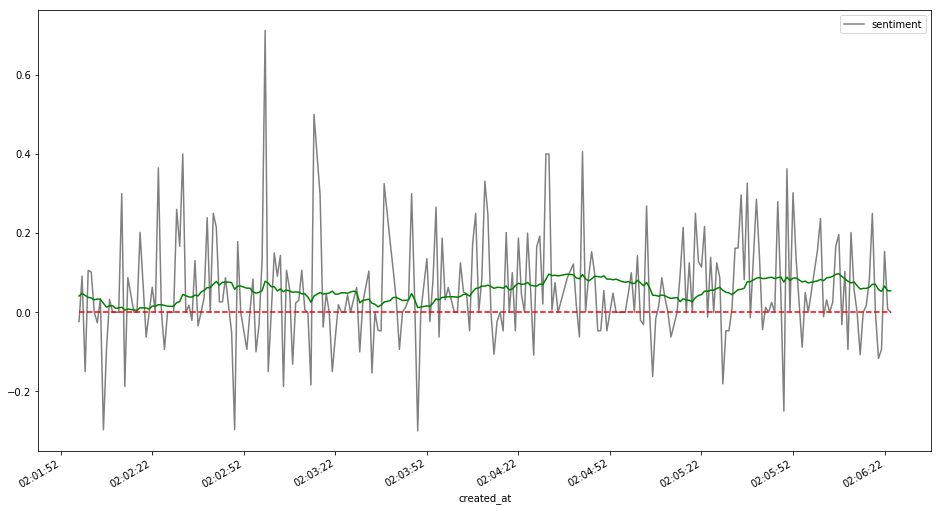

In [454]:
rcParams['figure.figsize'] = 16, 9

dfS[-250:].plot(kind='line', color='grey')

ax1 = dfS['sentiment'].rolling(30, min_periods=1).mean()[-250:].plot(kind='line', color='g')
plt.plot(dfS.index[-250:], [0]*len(dfS.index[-250:]), '--r')

In [104]:
stop = set(stopwords.words('english'))  # predefined list of "uninteresting" words

counter = Counter()

def nlargest(n, word_scores):
    """ Wrapper around heapq to return the n words with the largest count."""
    # word_scores: index 0=>word, 1=>count
    return heapq.nlargest(n, word_scores, key=lambda x: x[1])

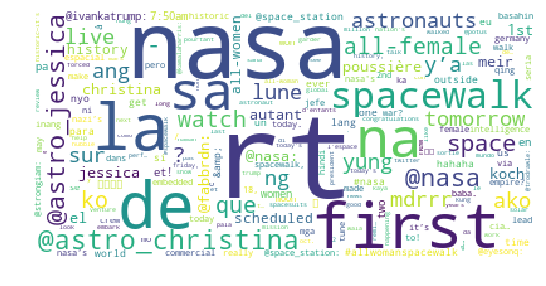

In [455]:
rcParams['figure.figsize'] = 9, 6
DISPLAY_EVERY = 100

try:
    for k in range(len(L)):
        try:
            tweet = L[k]['text']
            for word in tweet.lower().split():
                if word not in stop and 'http' not in word:
                    counter[word] += 1
            if k % DISPLAY_EVERY == (DISPLAY_EVERY - 1):
                wordcloud = WordCloud(background_color='white'#, collocations=False #, 
                                      #width=1600, height=800
                                     ).fit_words(counter)
                plt.axis("off")
                display.clear_output(wait=True)
                plt.imshow(wordcloud)
                display.display(plt.gcf())
        except:
            pass
    display.clear_output(wait=True)
except KeyboardInterrupt:
    pass

In [456]:
nlargest(10, counter.items())

[('rt', 26139),
 ('nasa', 14752),
 ('de', 5473),
 ('la', 5413),
 ('first', 5130),
 ('na', 3812),
 ('sa', 3712),
 ('spacewalk', 3468),
 ('@astro_christina', 3264),
 ('@astro_jessica', 2939)]

In [457]:
#L = [x for x in L if x]

In [458]:
#Collect only the tweets
T = []
for tweet in L:
    T.append(tweet['text'])

In [459]:
BATCH_SIZE = 102
CLUSTER_SIZE = 6

kmeans = MiniBatchKMeans(n_clusters=CLUSTER_SIZE)

def batch(iterable, size):
    """ batch("ABCDEFG", 3) -> ABC DEF G """
    sourceiter = iter(iterable)
    while True:
        batchiter = islice(sourceiter, size)
        yield chain([next(batchiter)], batchiter)

In [460]:
with open("dictnostops.txt") as fh:
    words = [line.strip() for line in fh.readlines()]
    word_to_index = { word: k for k, word in enumerate(words) }

In [461]:
def wordclouds(wordcounts):
    wordclouds = [WordCloud().fit_words(Counter({k:v for (k,v) in dict(counts).items() if v > 0})) for counts in wordcounts]
    fig, axes = plt.subplots(2,2)
    display.clear_output(wait=True)
    for k, (ax, wordcloud) in enumerate(zip(axes.flatten(), wordclouds)):
        ax.axis("off")
        ax.imshow(wordcloud)
        ax.set_title("Topic %d" % k)
    display.display(fig)
    fig.clear()

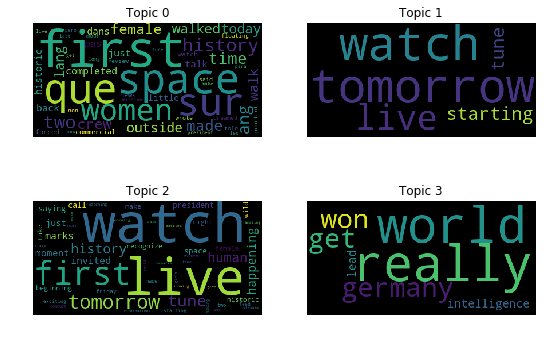

/Users/Nel/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: DeprecationWarning: generator 'batch' raised StopIteration
  from ipykernel import kernelapp as app


<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

In [462]:
try:
    for tweets in batch(T, BATCH_SIZE):
        mat = sp.sparse.dok_matrix((BATCH_SIZE, len(words)))
        for row, tweet in enumerate(tweets):
            for word in tweet.lower().split():
                if word in word_to_index:
                    mat[row, word_to_index[word]] = 1.
        kmeans.partial_fit(mat.tocsr())
        wordcounts = [nlargest(50, zip(words, kmeans.cluster_centers_[i])) for i in range(kmeans.n_clusters)]
        wordclouds(wordcounts)
except:
    pass

In [463]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['user_description'].dropna())

In [464]:
#svd = TruncatedSVD(n_components=100, n_iter=7, random_state=42)

In [465]:
X.shape

(8317, 24424)

In [466]:
#X1 = svd.fit_transform(X)

In [467]:
#print(svd.explained_variance_ratio_) 

In [468]:
#print(svd.explained_variance_ratio_.sum())

In [469]:
#print(svd.singular_values_)

In [473]:
dfDBS = df['user_description'].dropna().reset_index()

In [490]:
clustering = DBSCAN(eps=1.1, min_samples=10).fit(X)

In [491]:
dfDBS['dbscan'] = clustering.labels_

In [492]:
dfDBS[dfDBS['dbscan'] == -1]

Empty DataFrame
Columns: [index, user_description, dbscan]
Index: []

In [385]:
dfDBS = pd.DataFrame(X1[:,:2], columns=['x', 'y'])[100:200]
dfDBS['text'] = df['text'][100:200]
dfDBS['dbscan'] = df['dbscan'][100:200]
dfDBS.head()

x         y                                               text  \
100  0.024172  0.020474  @Stephen90045069 @Matt_Clough @JamesRider3 @aS...   
101  0.065091  0.003486  RT @usembassyMVD: üì¢¬øTodav√≠a no te registraste ...   
102  0.011106  0.105359  RT @NASA_Marshall: Spacesuits are useful for m...   
103  0.016975  0.076805  RT @sayatttjaimeee: at\nsinong\ntanga\nang\nna...   
104  0.006977  0.025343  RT @CecaPereca26: Nasa vojska je sve modernizo...   

     dbscan  
100       0  
101       0  
102       0  
103       7  
104       0

In [386]:
len(dfDBS['dbscan'].unique())


14

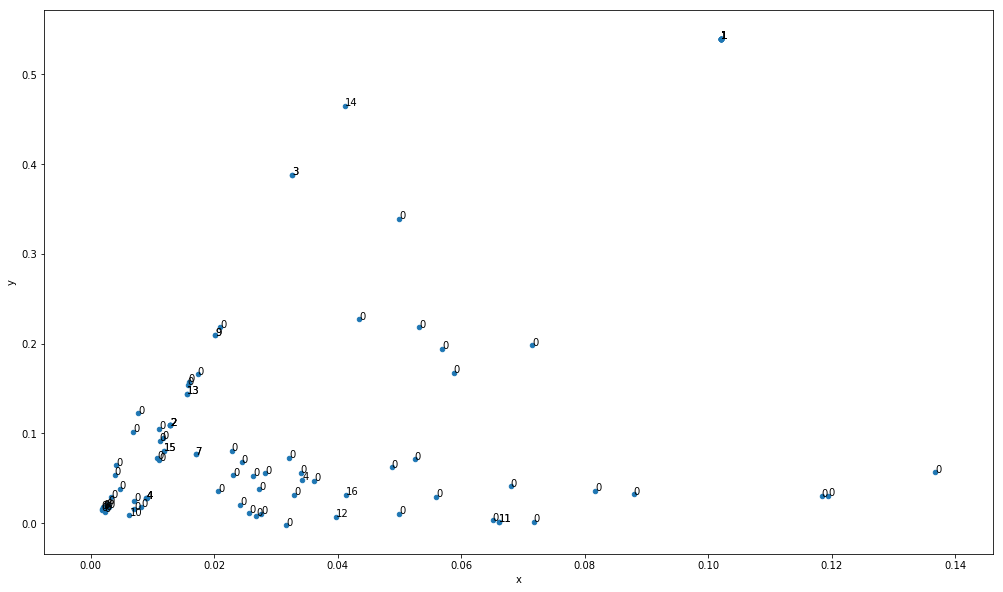

In [389]:
ax = dfDBS[['x','y']].plot.scatter(x='x', y='y')
for i, txt in enumerate(list(dfDBS['dbscan'])):
    ax.annotate(txt, (dfDBS['x'].loc[i+100], dfDBS['y'].loc[i+100]))

In [347]:
np.random.rand(3,)

array([ 0.46600021,  0.34850381,  0.42008035])

In [384]:
dfDBS

x         y      screen_name  dbscan
100  0.024172  0.020474      OscarsWild1       0
101  0.065091  0.003486     _diaz_camila       0
102  0.011106  0.105359   Astronomy_Nerd       0
103  0.016975  0.076805       jalina0208       7
104  0.006977  0.025343     pravi_genije       0
105  0.102098  0.539620            cntch       1
106  0.032940  0.031657  MargaritaDelf17       0
107  0.032551  0.387804   temple_terrace       3
108  0.102098  0.539620    CandaceHagen1       1
109  0.027256  0.038191     maglioqueira       0
110  0.015495  0.144385    BennyBeats111      13
111  0.020675  0.035858      Hope4Kansas       0
112  0.002006  0.017637  CassidyRKendall       0
113  0.053208  0.218405        momdude56       0
114  0.022808  0.080869      techpearce3       0
115  0.002253  0.012921    TamiiPaezPont       0
116  0.002879  0.017938         uhlecxis       0
117  0.032168  0.073206         pinhchen       0
118  0.041179  0.464790       RockitBill      14
119  0.006248  0.009091            M_07F      10
120  0.011102  0.069991        JairaDane       0
121  0.102098  0.539620     AndrzejNowak       1
122  0.006895  0.101719   preheat_to_375       0
123  0.003267  0.029025       zaellanken       0
124  0.020184  0.209248        gary_shaz       9
125  0.102098  0.539620  derekhayes_usmc       1
126  0.066099  0.001480         alargicl      11
127  0.007683  0.122651            PJrtx       0
128  0.102098  0.539620  patrick85191787       1
129  0.009032  0.027716    fester_thomas       4
..        ...       ...              ...     ...
170  0.033969  0.056193      CosmicBitxh       0
171  0.102098  0.539620     kazu17171893       1
172  0.012894  0.109383          CasadeC       2
173  0.026731  0.008318         aldo_pop       0
174  0.043468  0.227193             wibw       0
175  0.049950  0.010801     bok_dyuuuwan       0
176  0.102098  0.539620     142Countries       1
177  0.001767  0.014525    daniellamalda       0
178  0.012894  0.109383    madeinitaly67       2
179  0.102098  0.539620     angelus_0923       1
180  0.102098  0.539620        ritheen46       1
181  0.032551  0.387804    repairnoutbuk       3
182  0.071734  0.001760          madbydm       0
183  0.036223  0.047440     isabelatecno       0
184  0.049960  0.338922   chicagotribune       0
185  0.055964  0.029509         GauchaZH       0
186  0.102098  0.539620   gadgetfreaksta       1
187  0.004154  0.064600   Garrett_50_Cal       0
188  0.102098  0.539620    lanell_nelson       1
189  0.056876  0.194576  EcoInternetDrGB       0
190  0.028215  0.055989          svertla       0
191  0.002443  0.019234        mimirssx_       0
192  0.015667  0.154540         stirunel       0
193  0.004693  0.038483    iam_anjelly07       0
194  0.011156  0.092042      JustMePammy       0
195  0.023045  0.053406   AreYouAwkeYet1       0
196  0.081700  0.036513           YV5SEL       0
197  0.025625  0.011815          PotJan3       0
198  0.039662  0.007524       D0ug_Viana      12
199  0.011870  0.080899  Airwind57525260      15

[100 rows x 4 columns]

In [390]:
df[df['dbscan'] == 0]['text']

0       RT @riahfab: Ikaw na nasa bus/jeep na antok na...
2                   nasa panaginip nanaman kita kanina:))
4       NASA's Hubble Telescope Gives Best Look Yet at...
5       @SpideyChief Not to mention how NASA recently ...
6       RT @smart_whit: #TheTenCommandments it‚Äôs not f...
8       RT @wfryer: Getting ready for #STEAM night in ...
9       RT @elmundoes: La NASA ya tiene los trajes par...
10      RT @NASA_SLS: As NASA goes forward to the Moon...
11      RT @SmartTalentUY: #Agenda &gt;&gt;&gt; üõ∞üöÄ Est...
15      RT @apod: [RPT] Moons of Saturn: https://t.co/...
19      RT @SinEmbargoMX: C√°mara de la NASA capta la m...
20      RT @NASA: üëã @NASAInSight\n üëã @MarsCuriosity\nT...
21      RT @weatherindia: . @NASA is planning to land ...
22      RT @scosh_svnit: NASA's Hubble Telescope Gives...
23      RT @NASAJPL: Ruptures in Ridgecrest\n \nUsing ...
24      Our very own Katelyn Hertel, (@Katers_Potaters...
25      RT @elgranqenk: Primer cometa interestelar cap...

## Geospatial Analysis

## We extracted the location information from the tweets that had it so let's see how many did.

In [391]:
df.location.dropna()

1336    {'type': 'Point', 'coordinates': [112.72278627...
3457    {'type': 'Point', 'coordinates': [121.05386257...
6462    {'type': 'Point', 'coordinates': [-78.8962636,...
Name: location, dtype: object

In [392]:
#df = df.drop(3350, axis=0)

## That's not very promising. What else can we do to get geospatial information? We can look into the 'place' key.

In [393]:
df.place.dropna()

248     {'id': '3b77caf94bfc81fe', 'url': 'https://api...
249     {'id': '0087ad0f1b6dfcc8', 'url': 'https://api...
267     {'id': '3b77caf94bfc81fe', 'url': 'https://api...
313     {'id': '01516da6022dca08', 'url': 'https://api...
321     {'id': '521b6f591c4b3ce8', 'url': 'https://api...
377     {'id': '006523c50dfe9086', 'url': 'https://api...
459     {'id': '01e93ed535e05b29', 'url': 'https://api...
485     {'id': '013379ee5729a5e6', 'url': 'https://api...
661     {'id': '07d9ec9cc0086001', 'url': 'https://api...
778     {'id': '3797791ff9c0e4c6', 'url': 'https://api...
868     {'id': '01d7c74272e5eafe', 'url': 'https://api...
961     {'id': '5579f6b17e36847b', 'url': 'https://api...
1012    {'id': '003d47f62835a9f1', 'url': 'https://api...
1063    {'id': '00fc4c873d8a5e32', 'url': 'https://api...
1094    {'id': 'd6819fe60643ebc1', 'url': 'https://api...
1117    {'id': '4ec01c9dbc693497', 'url': 'https://api...
1155    {'id': '0fa65e5e6fbf3eb8', 'url': 'https://api...
1214    {'id':

In [394]:
df.place.loc[248]

{'id': '3b77caf94bfc81fe',
 'url': 'https://api.twitter.com/1.1/geo/id/3b77caf94bfc81fe.json',
 'place_type': 'city',
 'name': 'Los Angeles',
 'full_name': 'Los Angeles, CA',
 'country_code': 'US',
 'country': 'United States',
 'bounding_box': {'type': 'Polygon',
  'coordinates': [[[-118.668404, 33.704538],
    [-118.668404, 34.337041],
    [-118.155409, 34.337041],
    [-118.155409, 33.704538]]]},
 'attributes': {}}

## Not all tweets have a 'place' key but there are definitely more of those than with a location. Inside 'place' there are coordinates for a geographical bounding box so let's compute its centroid and use that as a point of reference for location.

In [396]:
df1 = df[['place', 'text']].dropna().reset_index()
df1['centroid_lat'] = df1.apply(lambda x: np.array(x['place']['bounding_box']['coordinates'][0]).mean(axis=0)[0], 1)
df1['centroid_lon'] = df1.apply(lambda x: np.array(x['place']['bounding_box']['coordinates'][0]).mean(axis=0)[1], 1)

df1 = df1.groupby(['centroid_lat', 'centroid_lon'])['text'].count().reset_index()
df1.columns = ['centroid_lat', 'centroid_lon', 'count']

#### What are the most common centroids?

In [397]:
df1.sort_values(by='count', ascending=False)

centroid_lat  centroid_lon  count
33    -77.014398     38.898603      3
65    120.983987     14.591457      3
70    121.062736     14.683012      2
21    -83.804475     27.698682      2
44    -46.595546    -23.682803      2
53     24.830963     65.862802      2
38    -73.968542     40.780709      2
68    121.033212     14.546499      2
48     -3.703508     40.477795      2
4    -118.411907     34.020789      2
2    -122.330602     47.614817      2
84    123.247827     13.640892      1
63    120.818031     13.984376      1
62    120.728789     15.192721      1
88    135.512242     35.008375      1
61    120.588440     16.402280      1
60    112.724706     -7.275803      1
59    104.016823      1.050769      1
58     91.594285     22.897541      1
57     50.573873     25.952302      1
83    123.046833     14.079588      1
56     46.202082      5.163854      1
55     28.060613    -26.058708      1
54     27.006511     38.407930      1
89    138.792756    -35.097686      1
52     11.244817     43.780709      1
51      0.314300     42.308346      1
50     -2.136197     49.245837      1
64    120.969501     14.430456      1
87    125.443261      7.317582      1
..           ...           ...    ...
11    -97.817354     26.176254      1
10   -101.215994     19.918374      1
9    -104.976767     39.534794      1
8    -110.915573     32.189391      1
7    -111.928142     33.392884      1
6    -111.931711     34.168253      1
5    -117.730006     33.560742      1
3    -119.827182     39.512436      1
22    -82.400308     34.783014      1
24    -80.737633     28.258804      1
46     -8.422813     43.345661      1
25    -80.650764     28.586010      1
1    -122.555439     38.093358      1
43    -47.436633    -23.470006      1
42    -49.288460    -25.495249      1
41    -66.058368     18.384166      1
40    -71.683502     42.036939      1
39    -73.789133      5.108820      1
37    -74.278855     40.266520      1
36    -74.315005     40.569527      1
35    -75.483936     40.591825      1
34    -75.699457     39.736777      1
32    -77.090869     38.817380      1
31    -78.855078     35.723200      1
30    -79.272570     43.629311      1
29    -79.420865     38.003376      1
28    -79.428376     43.903509      1
27    -79.674847     44.371263      1
26    -80.201097     44.080757      1
90    153.369361    -27.954221      1

[91 rows x 3 columns]

### Where are users located according to their bios?

In [398]:
df.groupby('user_location')['text'].count().sort_values(ascending=False)

user_location
United States                     122
Republic of the Philippines        77
Los Angeles, CA                    50
USA                                39
Paris, France                      36
France                             36
New York, NY                       36
Washington, DC                     35
California, USA                    34
Worldwide                          29
Venezuela                          26
Earth                              25
Florida, USA                       25
Texas, USA                         22
Philippines                        22
London, England                    21
Houston, TX                        21
Comunidad de Madrid, Espa√±a        19
Ile-de-France, France              19
Chicago, IL                        18
India                              17
San Francisco, CA                  17
üáµüá≠                                 16
Australia                          16
San Diego, CA                      16
Canada                       

In [399]:
df['location'].dropna()

1336    {'type': 'Point', 'coordinates': [112.72278627...
3457    {'type': 'Point', 'coordinates': [121.05386257...
6462    {'type': 'Point', 'coordinates': [-78.8962636,...
Name: location, dtype: object

In [400]:
# Go through all tweets and add locations to 'coordinates' dictionary
coordinates = {'latitude': [], 'longitude': []}
for index, row in df.iterrows():
    try:
        
        #location = geolocator.geocode(user_loc)
        # If coordinates are found for location
        if row['location']['coordinates']:
            coordinates['latitude'].append(row['location']['coordinates'][0])
            coordinates['longitude'].append(row['location']['coordinates'][1])
            
    # If too many connection requests
    except:
        pass

In [401]:
coordinates

{'latitude': [112.72278627, 121.05386257, -78.8962636],
 'longitude': [-7.27586109, 14.62204492, 35.7372126]}

### Lets now map the information we have from tweet's location and bounding box centroids.

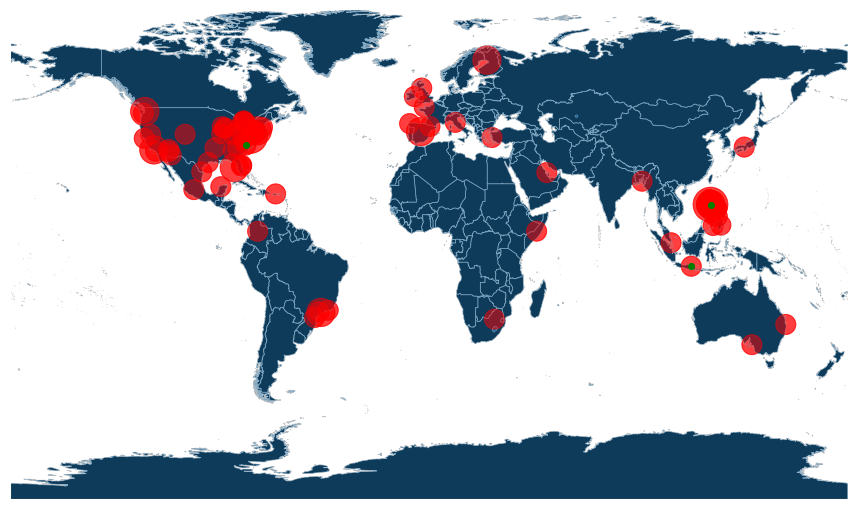

In [402]:
shp_link = './ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp'
shp = ps.open(shp_link)
some = [True for i in ps.open(shp_link)] #bool(rdm.getrandbits(1))


fig = figure(figsize=(15,9))

base = maps.map_poly_shp(shp)
base.set_facecolor('black')
base.set_linewidth(0.75)
base.set_edgecolor('0.8')
some = maps.map_poly_shp(shp, which=some)
some.set_alpha(0.5)
some.set_linewidth(0.)
ptsC = scatter(df1['centroid_lat'], df1['centroid_lon'], s=400*df1['count'], alpha=.5)
ptsC.set_color('red')

pts = scatter(coordinates['latitude'], coordinates['longitude'])
pts.set_color('green')

ax = maps.setup_ax([base, some, ptsC, pts], [shp.bbox, shp.bbox, shp.bbox, shp.bbox])

fig.add_axes(ax)
show()

(2000, 10)

In [403]:
#df.to_csv('dataT.csv', index=False)

In [ ]:
#use the sentiment to color

In [526]:
df['user_description']

0            Have Faith, Hope and Love üòáüíï || Astrophile ‚ú®
1       üá≥üá¥‚ù§Ô∏è I love ivanka trump üåπüá∏üá™ l love you üíïü•Ä sor...
2                                                       üíë
3         Conservative Veterans wife/born again Christian
4       Society for Cultivation of Sciences and Humani...
5       Sci-fi fan, dinosaur enthusiast, and weeb. Ama...
6                                                    None
7       love food , dogs , President Trump and his fam...
8                                                    None
9                           Entre Sevilla y Gran Canaria.
10      Go NASA!!!Go Bar√ßa!!Two different but determin...
11      Soci√≥loga, interesada en generar sinergias ent...
12                                                   None
13                                No boi I have a smile üòä
14      Horsesüêé | Entrepreneurship, Social Development...
15                                                   None
16      Born in Motown/Hocke

In [66]:
#dfA = pd.read_csv('dataT.csv')

In [70]:
def Converter(x):
    try:
        return eval(x)
    except:
        None

In [71]:
#dfA['raw_data'] = dfA.apply(lambda x: Converter(x['raw_data']), 1)

In [74]:
#L = list(dfA['raw_data']) + L

In [ ]:
#L = [x for x in L if x]